## Projet :Système de Recommandation de Produits Complémentaires
	## Description : Ce projet consiste à développer un moteur de recommandation qui suggère des produits complémentaires aux clients lors de leurs achats en ligne.  ###L'objectif est d'augmenter le revenu par client grâce à des ventes croisées.

	### Technologies : Machine Learning, Filtrage Collaboratif, Algorithmes de Recommandation
	### Ensemble de Données : "Online Retail Dataset" qui contient des transactions d'un détaillant en ligne.
	### Référence : Amazon est un exemple célèbre qui utilise ce type de système pour augmenter ses ventes.

## Importing the librairies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings, re, os
import plotly.express as px
#from sklearn.pairwise import cosine_similarity
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.metrics.pairwise import cosine_similarity

## First Analyse

In [2]:
## Load the data
df = pd.read_csv('../data/online_retail.csv')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
## the shape of dataset and the columns number
df.shape, df.columns.tolist()

((541909, 8),
 ['InvoiceNo',
  'StockCode',
  'Description',
  'Quantity',
  'InvoiceDate',
  'UnitPrice',
  'CustomerID',
  'Country'])

## Analyse exploratoire des données

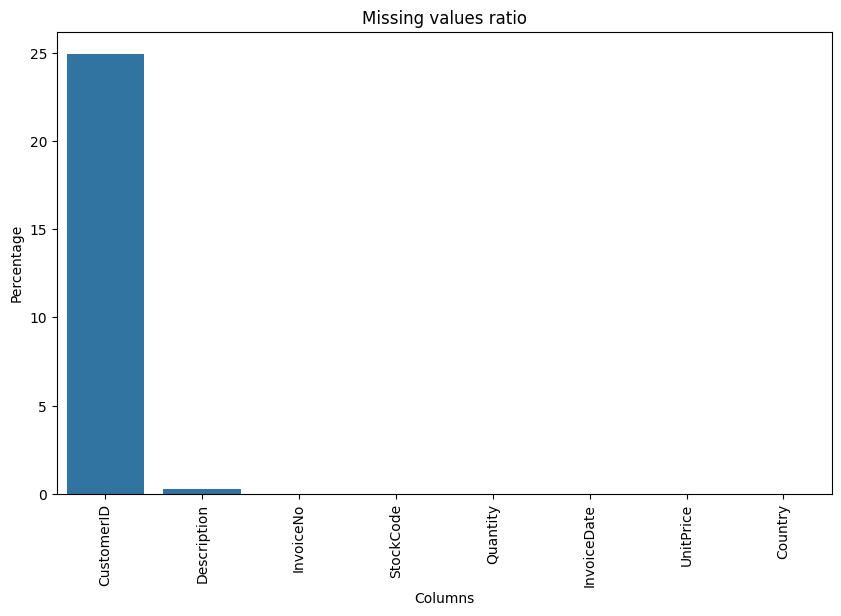

In [4]:
## describe of data
df.describe()

## the missing values of dataset
missing_values = df.isnull().sum()
## pourcentage of missing values
ratio = missing_values / df.shape[0] * 100
missing_data = pd.DataFrame({'missing_values': missing_values, 'ratio': ratio})
missing_data = missing_data.sort_values(by='ratio', ascending = False)
missing_data

## visualization of missing values
plt.figure(figsize=(10, 6))
sns.barplot(x=missing_data.index, y=missing_data['ratio'])
plt.title('Missing values ratio')
plt.xlabel('Columns')
plt.ylabel('Percentage')
plt.xticks(rotation=90)
plt.show()

In [ ]:
ratio, missing_data

(InvoiceNo       0.000000
 StockCode       0.000000
 Description     0.268311
 Quantity        0.000000
 InvoiceDate     0.000000
 UnitPrice       0.000000
 CustomerID     24.926694
 Country         0.000000
 dtype: float64,
              missing_values      ratio
 CustomerID           135080  24.926694
 Description            1454   0.268311
 InvoiceNo                 0   0.000000
 StockCode                 0   0.000000
 Quantity                  0   0.000000
 InvoiceDate               0   0.000000
 UnitPrice                 0   0.000000
 Country                   0   0.000000)

In [6]:
## take informations
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


In [7]:
df.tail()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680.0,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680.0,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680.0,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680.0,France
541908,581587,22138,BAKING SET 9 PIECE RETROSPOT,3,2011-12-09 12:50:00,4.95,12680.0,France


In [8]:
## calculate the total price of each product
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']
df['Country'].value_counts()
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34


In [9]:
## format the date of invoicedata
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['Year'] = df['InvoiceDate'].dt.year
df['Month'] = df['InvoiceDate'].dt.month
df['Day'] = df['InvoiceDate'].dt.day
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010,12,1


In [10]:
## gerer les valeurs manquantes
## replace the missing values of the description column by the most frequent value
most_frequent = df['Description'].mode()[0]
df['Description'] = df['Description'].fillna(most_frequent)

#€ for coustomerID
median_customerID = df['CustomerID'].median()
df['CustomerID'] = df['CustomerID'].fillna(median_customerID)

In [ ]:
df['CustomerID'] = df['CustomerID'].astype('int32')
df.dtypes

InvoiceNo              object
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID              int32
Country                object
TotalPrice            float64
Year                    int32
Month                   int32
Day                     int32
dtype: object

In [12]:
df.isnull().sum(), df.duplicated().sum()

(InvoiceNo      0
 StockCode      0
 Description    0
 Quantity       0
 InvoiceDate    0
 UnitPrice      0
 CustomerID     0
 Country        0
 TotalPrice     0
 Year           0
 Month          0
 Day            0
 dtype: int64,
 np.int64(5268))

In [13]:
df.drop_duplicates(inplace=True)

In [14]:
## the data cleaned
data = df.copy()
data.sample(5)


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day
223836,556494,21430,SET/3 RED GINGHAM ROSE STORAGE BOX,3,2011-06-12 14:57:00,3.75,17802,United Kingdom,11.25,2011,6,12
361386,568346,22422,TOOTHPASTE TUBE PEN,1,2011-09-26 15:28:00,1.25,14096,United Kingdom,1.25,2011,9,26
505051,578999,20764,ABSTRACT CIRCLES SKETCHBOOK,1,2011-11-27 16:08:00,3.75,17595,United Kingdom,3.75,2011,11,27
415152,572517,22584,PACK OF 6 PANNETONE GIFT BOXES,2,2011-10-24 14:47:00,2.55,15068,United Kingdom,5.10,2011,10,24
365261,568703,22065,CHRISTMAS PUDDING TRINKET POT,42,2011-09-28 15:21:00,0.39,12748,United Kingdom,16.38,2011,9,28


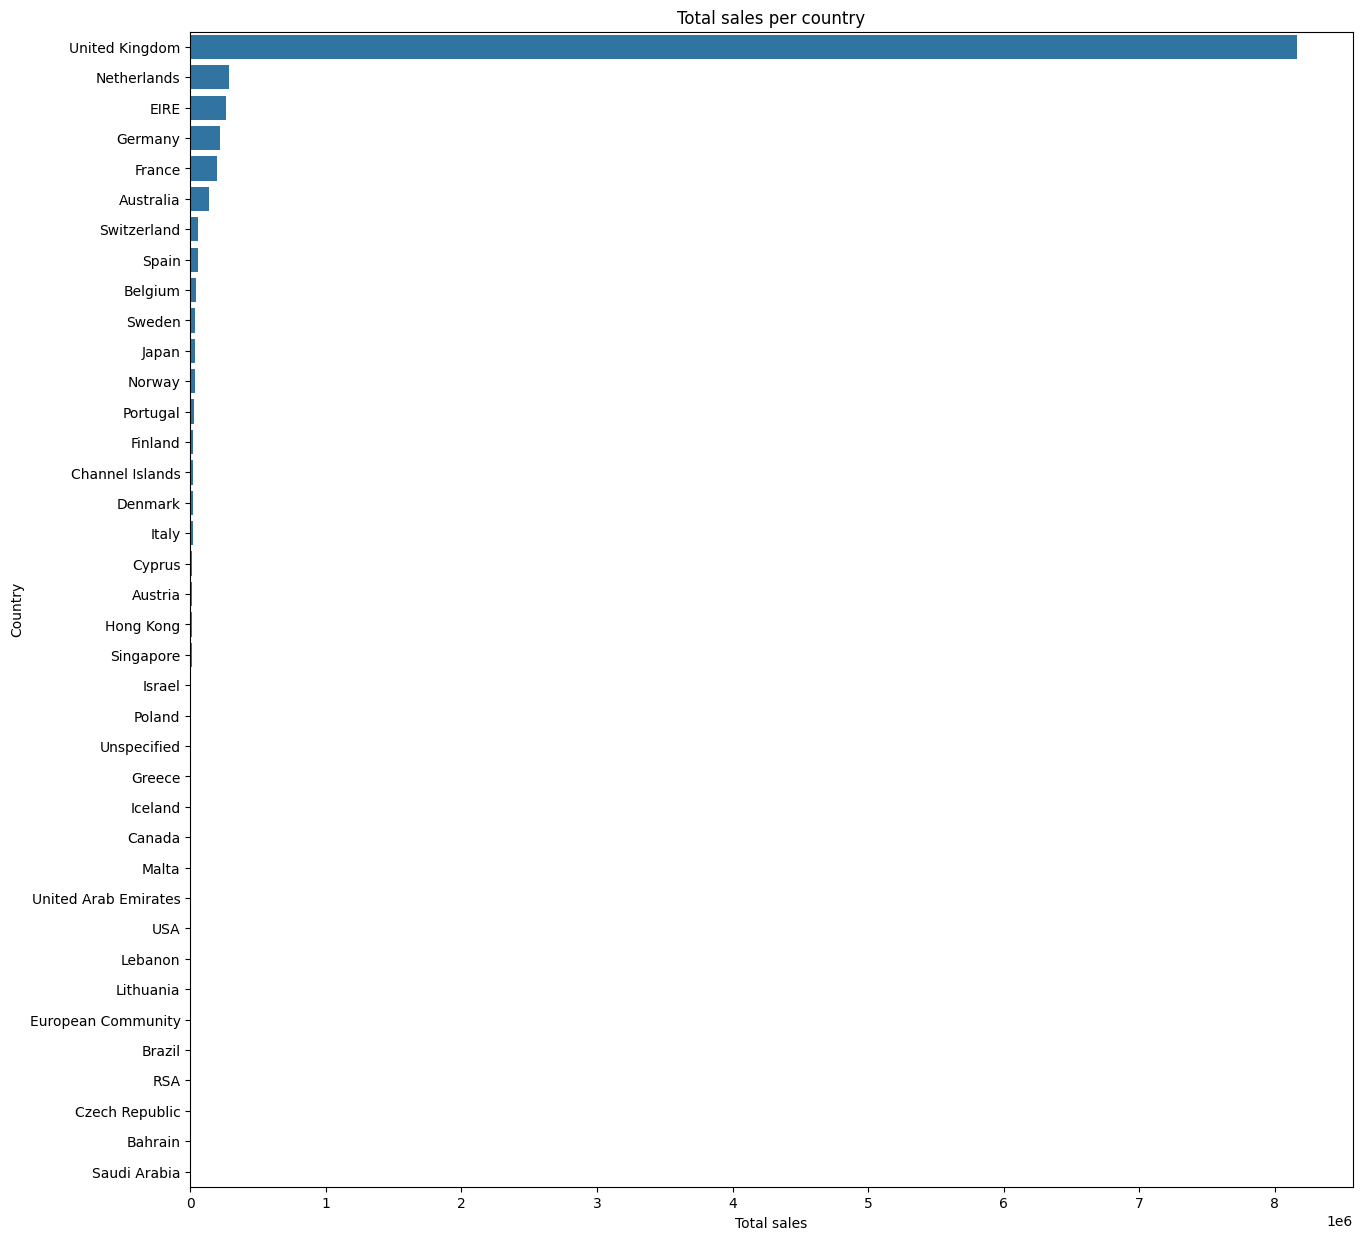

In [15]:
## top des pays avec le plus de commandes
top_country_sales = df.groupby('Country')['TotalPrice'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(15,15))
sns.barplot(x='TotalPrice', y='Country', data=top_country_sales)
plt.title('Total sales per country')
plt.xlabel('Total sales')
plt.ylabel('Country')
plt.show()

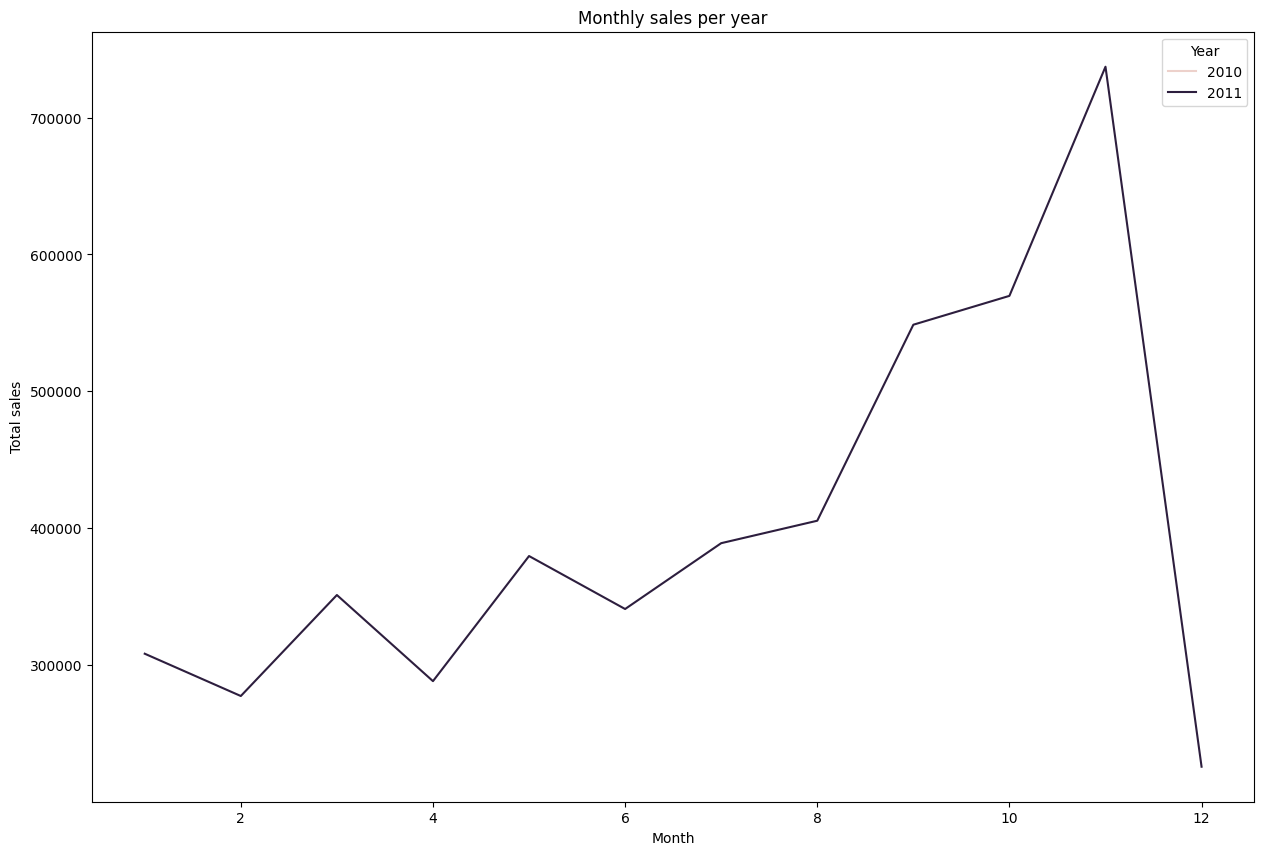

In [16]:
## nombre de commandes par mois et par année
monthly_sales = data.groupby(['Year', 'Month'])['Quantity'].sum().reset_index()
plt.figure(figsize=(15, 10))
sns.lineplot(x='Month', y='Quantity', hue='Year', data=monthly_sales)
plt.title('Monthly sales per year')
plt.xlabel('Month')
plt.ylabel('Total sales')
plt.show()

## Total quantités de produits commandés par mois et par année

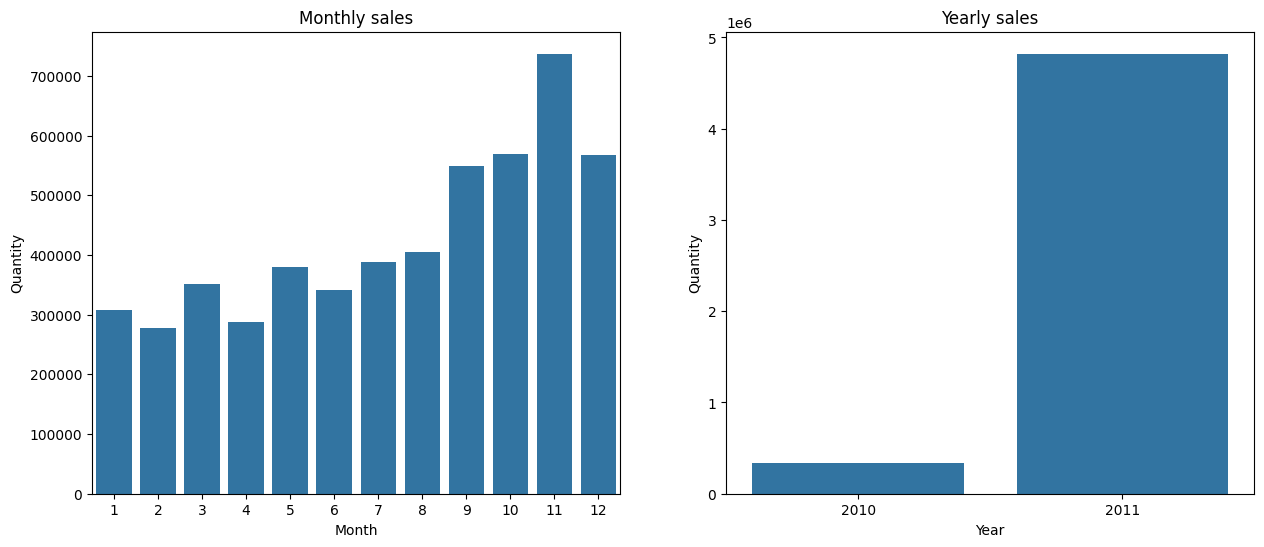

In [17]:
## total de quantité de produit vendu par mois
monthly_sales = data.groupby('Month')['Quantity'].sum().reset_index()
year_sales = data.groupby('Year')['Quantity'].sum().reset_index()

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
sns.barplot(x='Month', y='Quantity', data=monthly_sales, ax=ax[0])
sns.barplot(x='Year', y='Quantity', data=year_sales, ax=ax[1])
ax[0].set_title('Monthly sales')
ax[1].set_title('Yearly sales')
plt.show()

## Top des pays ayant plus de clients

/tmp/ipykernel_8450/3845118182.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  z = sns.barplot(x='CustomerID', y='Country', palette='Blues_r', data=top_country_customers)


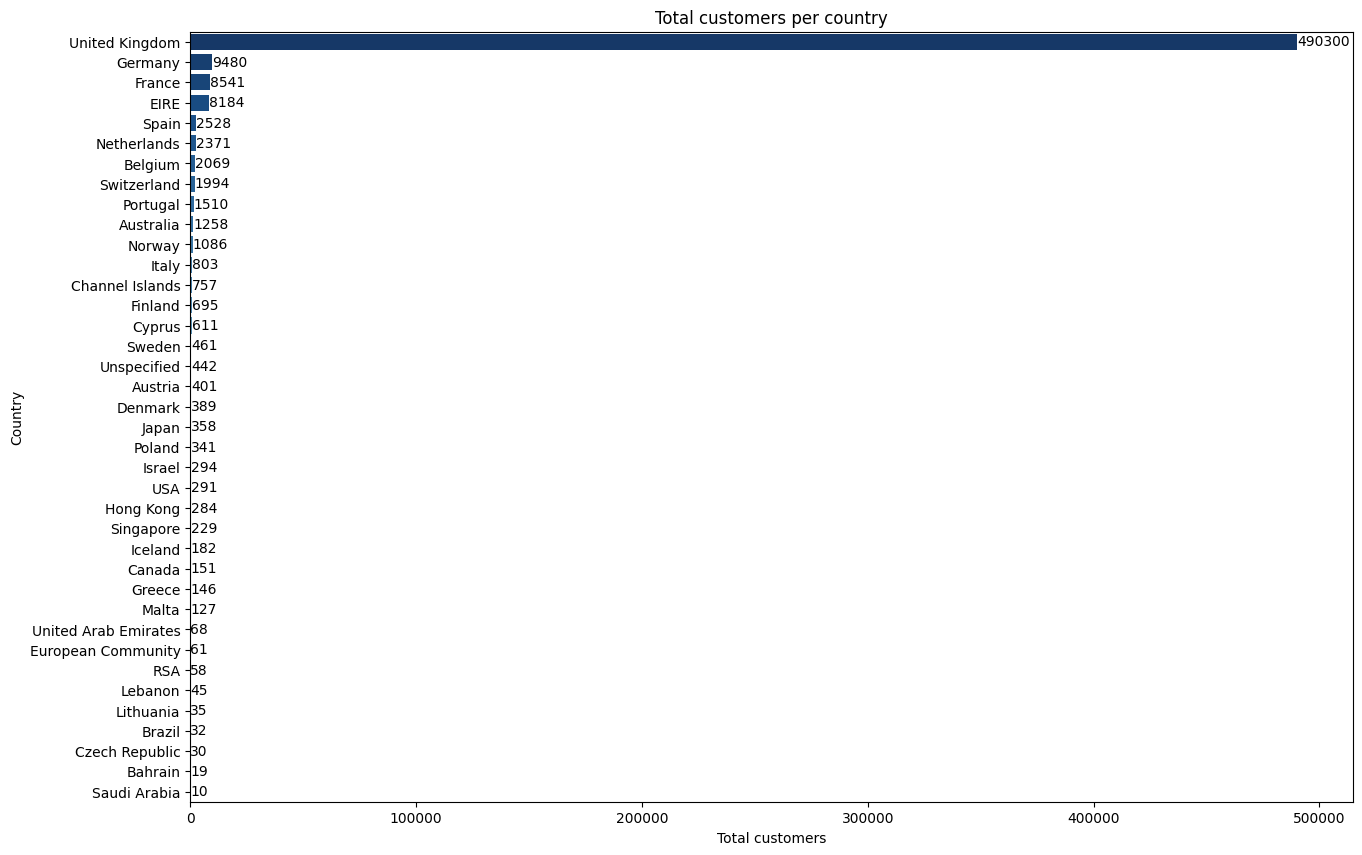

In [18]:
## top des pays ayant le plus de clients
top_country_customers = data.groupby('Country')['CustomerID'].count().reset_index().sort_values('CustomerID', ascending=False)
plt.figure(figsize=(15, 10))
z = sns.barplot(x='CustomerID', y='Country', palette='Blues_r', data=top_country_customers)
plt.title('Total customers per country')
plt.xlabel('Total customers')
plt.ylabel('Country')

for i in z.containers:
    z.bar_label(i, label_type='edge')

## Top 20 des produits les plus vendus

/tmp/ipykernel_8450/3915058546.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  z = sns.barplot(x='Quantity', y='Description', data=top_products.head(20), palette='viridis')


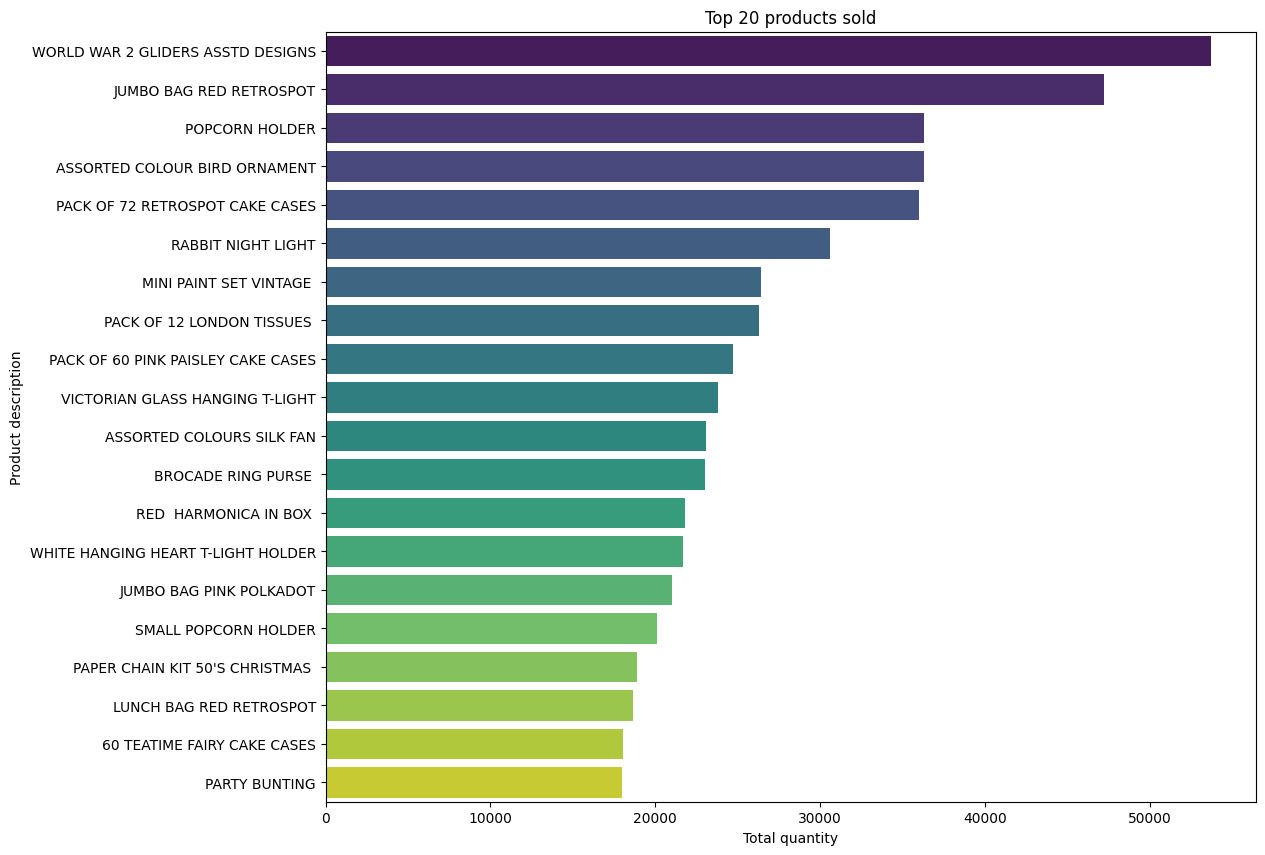

In [19]:
## top des produits les plus vendus
top_products = data.groupby('Description')['Quantity'].sum().reset_index().sort_values('Quantity', ascending=False)
plt.figure(figsize=(12, 10))
z = sns.barplot(x='Quantity', y='Description', data=top_products.head(20), palette='viridis')
plt.title('Top 20 products sold')
plt.xlabel('Total quantity')
plt.ylabel('Product description')
plt.show()
for y in z.containers:
	z.bar_label(y, label_type='edge')

## Top 20 des produits les plus vendus

/tmp/ipykernel_8450/4203769733.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  z = sns.barplot(x='TotalPrice', y='Description', data=total_price.head(20), palette='viridis')


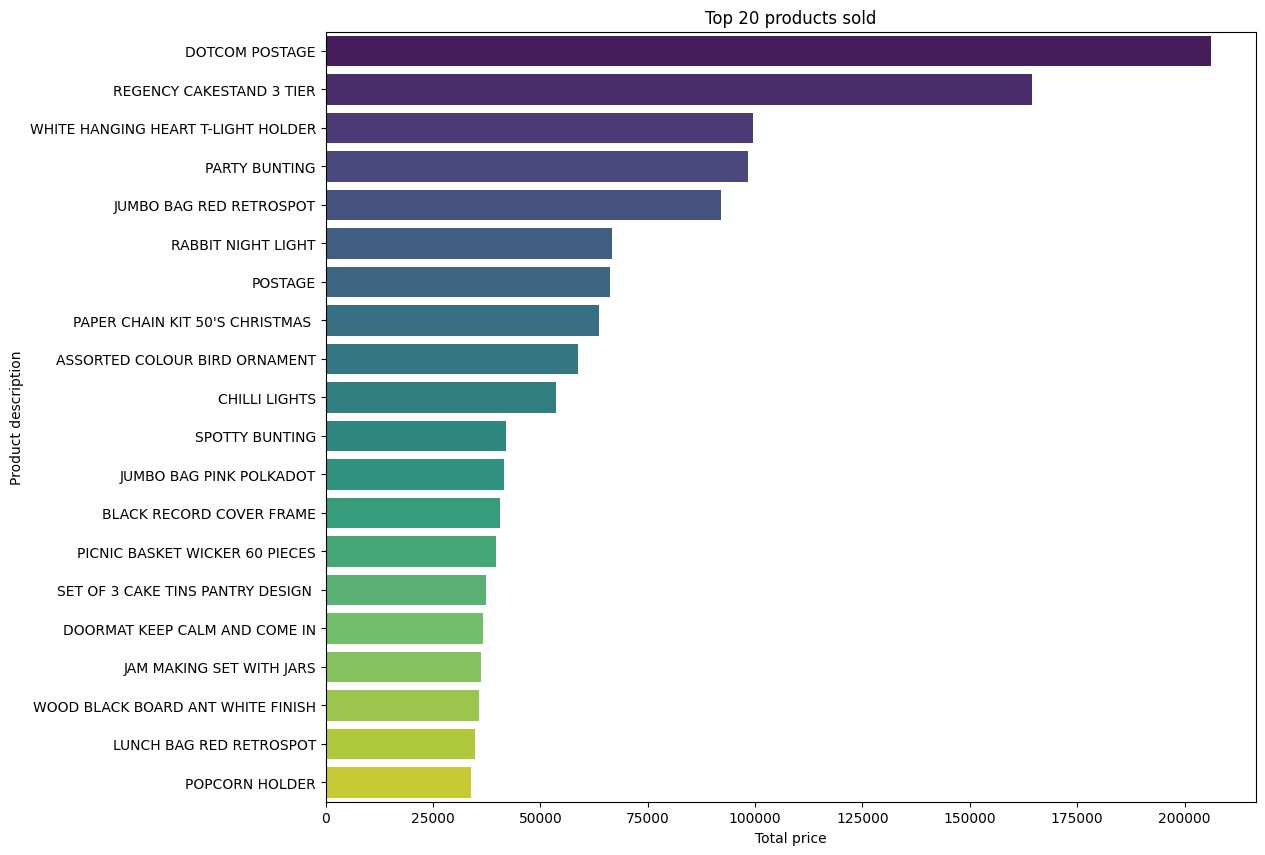

In [20]:
## total price de produit vendu
total_price = data.groupby('Description')['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending=False)
plt.figure(figsize=(12, 10))
z = sns.barplot(x='TotalPrice', y='Description', data=total_price.head(20), palette='viridis')
plt.title('Top 20 products sold')
plt.xlabel('Total price')
plt.ylabel('Product description')
plt.show()
for y in z.containers:
	z.bar_label(y, label_type='edge')


In [21]:
data.groupby('Description').count()

,InvoiceNo,StockCode,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day
Description,,,,,,,,,,,
4 PURPLE FLOCK DINNER CANDLES,39,39,39,39,39,39,39,39,39,39,39
50'S CHRISTMAS GIFT BAG LARGE,130,130,130,130,130,130,130,130,130,130,130
DOLLY GIRL BEAKER,178,178,178,178,178,178,178,178,178,178,178
I LOVE LONDON MINI BACKPACK,87,87,87,87,87,87,87,87,87,87,87
I LOVE LONDON MINI RUCKSACK,1,1,1,1,1,1,1,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...
wrongly marked carton 22804,1,1,1,1,1,1,1,1,1,1,1
wrongly marked. 23343 in box,1,1,1,1,1,1,1,1,1,1,1
wrongly sold (22719) barcode,1,1,1,1,1,1,1,1,1,1,1


In [22]:
data.groupby('Description').count()['Quantity'].reset_index()

,Description,Quantity
0,4 PURPLE FLOCK DINNER CANDLES,39
1,50'S CHRISTMAS GIFT BAG LARGE,130
2,DOLLY GIRL BEAKER,178
3,I LOVE LONDON MINI BACKPACK,87
4,I LOVE LONDON MINI RUCKSACK,1
...,...,...
4218,wrongly marked carton 22804,1
4219,wrongly marked. 23343 in box,1
4220,wrongly sold (22719) barcode,1
4221,wrongly sold as sets,1


## fitrer pour reperer les quantités négatives.

In [23]:
df_new = data[data['Quantity'] >0]
df_2 = data[data['Quantity'] < 0]
df_new.head()


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1


In [24]:
print(df_new.shape)
print(df_new.info())
print(df_new.describe())

(526054, 12)
<class 'pandas.core.frame.DataFrame'>
Index: 526054 entries, 0 to 541908
Data columns (total 12 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    526054 non-null  object        
 1   StockCode    526054 non-null  object        
 2   Description  526054 non-null  object        
 3   Quantity     526054 non-null  int64         
 4   InvoiceDate  526054 non-null  datetime64[ns]
 5   UnitPrice    526054 non-null  float64       
 6   CustomerID   526054 non-null  int32         
 7   Country      526054 non-null  object        
 8   TotalPrice   526054 non-null  float64       
 9   Year         526054 non-null  int32         
 10  Month        526054 non-null  int32         
 11  Day          526054 non-null  int32         
dtypes: datetime64[ns](1), float64(2), int32(4), int64(1), object(4)
memory usage: 44.1+ MB
None
            Quantity                    InvoiceDate      UnitPrice  \
count  526054.

## identifier la valeur des clients

### classez les clients par leur contribution au chiffres d'affaires

/tmp/ipykernel_8450/1985313900.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="CustomerID", y = 'TotalPrice', palette= "Set3", data = top_customers.head(10))


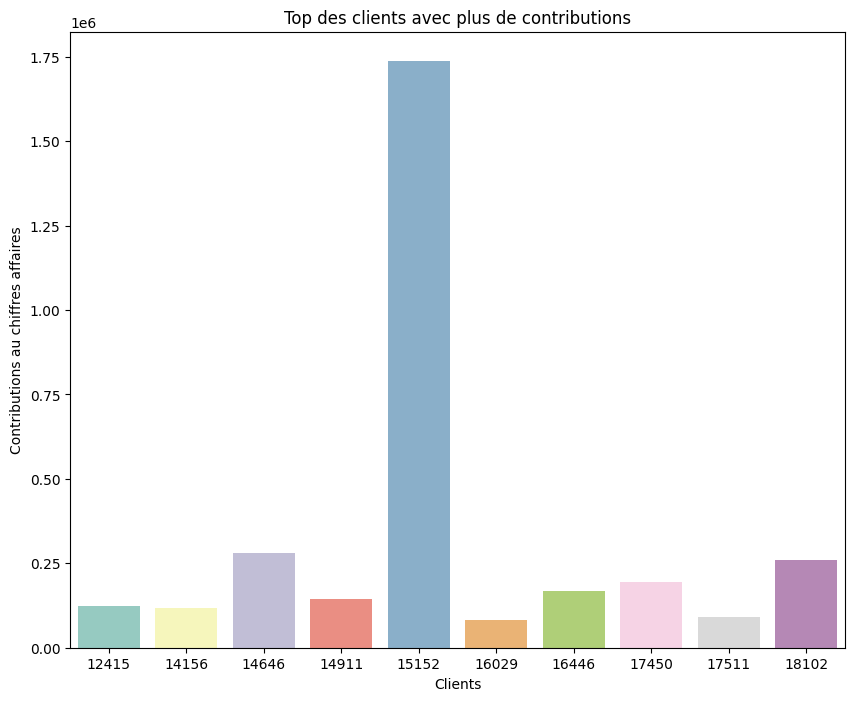

In [25]:
top_customers = df_new.groupby('CustomerID')['TotalPrice'].sum().reset_index().sort_values('TotalPrice', ascending = False)
plt.figure(figsize=(10,8))
sns.barplot(x="CustomerID", y = 'TotalPrice', palette= "Set3", data = top_customers.head(10))
plt.title('Top des clients avec plus de contributions')
plt.xlabel('Clients')
plt.ylabel('Contributions au chiffres affaires')
plt.show()

## Preparation des données pour les recommandations

	1. Création d'une matrice de transactions où les lignes sont les factures et les colonnes sont les produits
	2. Réductions de dimmensions: filtrez les produits pour eliminer les produits avec peu de commande(rends plus efficace l'analyse)

In [26]:
df_new

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,Year,Month,Day
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30,2010,12,1
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00,2010,12,1
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34,2010,12,1
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France,10.20,2011,12,9
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France,12.60,2011,12,9
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,12,9
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France,16.60,2011,12,9


In [27]:
transaction_matrice = df_new.groupby(['InvoiceNo', 'Description'])['Quantity'].sum().unstack().fillna(0)
transaction_matrice = transaction_matrice.applymap(lambda x: 1 if x>0 else 0)
transaction_matrice

/tmp/ipykernel_8450/639664616.py:2: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  transaction_matrice = transaction_matrice.applymap(lambda x: 1 if x>0 else 0)


Description,4 PURPLE FLOCK DINNER CANDLES,50'S CHRISTMAS GIFT BAG LARGE,DOLLY GIRL BEAKER,I LOVE LONDON MINI BACKPACK,I LOVE LONDON MINI RUCKSACK,NINE DRAWER OFFICE TIDY,OVAL WALL MIRROR DIAMANTE,RED SPOT GIFT BAG LARGE,SET 2 TEA TOWELS I LOVE LONDON,SPACEBOY BABY GIFT SET,...,returned,taig adjust,test,to push order througha s stock was,website fixed,wrongly coded 20713,wrongly coded 23343,wrongly marked,wrongly marked 23343,wrongly sold (22719) barcode
InvoiceNo,,,,,,,,,,,,,,,,,,,,,
536365,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536366,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536367,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536368,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
536369,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
581586,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
581587,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A563185,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
transaction_matrice = transaction_matrice.loc[:, transaction_matrice.sum(axis=0) >5]

## Contrusction du modèle de recommandation

A. Règles d'association(Apriori)
	.La règle d'association Apriori permet d'identifier les produits souvent achétés ensemble.
	. Verifie les produits complémentaires les plus pertinents (en calculant le haut lift, haute confiance).
	. elle utilise la règle selon laquellle si un client achète le produit A, il est probable qu'il achhète le produit B


In [29]:
from mlxtend.frequent_patterns import apriori

## frequent itemsets 
frequent_itemset = apriori(transaction_matrice, min_support = 0.01, use_colnames = True)
print(frequent_itemset)

ModuleNotFoundError: No module named 'mlxtend'

In [ ]:
## règles d'association
## calcul le support, la confiance et le lift pour chaque regle

from mlxtend.frequent_patterns import association_rules

rules = association_rules(frequent_itemset, metric = "lift", min_threshold = 1)
rules[['antecedents', "consequents", 'support', 'confidence', 'lift']]

## similarity

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

## score de similarity
similarity_scores = cosine_similarity(transaction_matrice)
similarity_scores